# EDA on 1 Year weather training data from OTPW 

**TO DO:**
- Check that all rows are within the US bounding box mentioned in data dictionary. 
- Check which of the variables are mandatory, and which optional


## Import libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.ml.feature import Imputer

import folium



## Setup cluster

In [0]:

blob_container = "261storagecontainer"  
storage_account = "261storage" 
secret_scope = "261_team_6_1_spring24_scope"  
secret_key = "team_6_1_key"  
team_blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net" 


# blob storage is mounted here.
mids261_mount_path = "/mnt/mids-w261"

# SAS Token: Grant the team limited access to Azure Storage resources
spark.conf.set(
    f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
    dbutils.secrets.get(scope=secret_scope, key=secret_key),
)

In [0]:
# # see what's in the blob storage root folder
display(dbutils.fs.ls(f"{team_blob_url}"))

In [0]:
# mount
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

## 1. Load data and view schema

In [0]:
# Weather data
df_weather = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_1y/")

## 2. Dimensions

- All variables are typecast as string (except for `YEAR`, which is integer)
- We should typecast them to their original types

In [0]:
print(f'There are {df_weather.count()} rows and {len(df_weather.columns)} columns in the df_weather dataframe')


## 2.1 Change datatype for string columns which are actually numeric

In [0]:
# type cast as integers
this_is_int = ['SOURCE', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlyWetBulbTemperature', 'HourlyWindGustSpeed', 'HourlyWindSpeed', 'Sunrise', 'Sunset', 'DailyAverageDewPointTemperature','DailyAverageDryBulbTemperature', 'DailyAverageRelativeHumidity', 'DailyCoolingDegreeDays', 'DailyHeatingDegreeDays', 'DailyMaximumDryBulbTemperature', 'DailyMinimumDryBulbTemperature', 'DailyPeakWindDirection', 'DailyPeakWindSpeed', 'DailySnowDepth', 'DailySustainedWindDirection', 'DailySustainedWindSpeed', 'BackupElevation', 'YEAR', 'DailyAverageWetBulbTemperature']

this_is_float = ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'HourlyAltimeterSetting', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'DailyAverageSeaLevelPressure', 'DailyAverageStationPressure', 'DailyAverageWindSpeed', 'DailyDepartureFromNormalAverageTemperature', 'DailyPrecipitation', 'DailySnowfall', 'BackupDistance', 'BackupLatitude', 'BackupLongitude']

In [0]:
#typecast as int or float
df_weather = df_weather.select(*[
    F.col(c).cast('int').alias(c) if c in this_is_int else
    F.col(c).cast('float').alias(c) if c in this_is_float else
    F.col(c)
    for c in df_weather.columns
])

# change date to date
df_weather = df_weather.withColumn('DATE', F.to_date('DATE'))

## 2.2 Check that all stations mentioned are within the US

- Continental US bounding box: 

In [0]:
# continental_north = 49.3457868 # north lat
# continental_west = -124.7844079 # west long
# continental_east = -66.9513812 # east long
# continental_south =  24.7433195 # south lat 

df_weather.cache()

territories_west = -180 #includes westernmost point of Alaska
territories_east = -65 # includes Puerto Rico and the US Virgin Islands
territories_south = 14 #includes Wake Island and the southernmost point of Hawaii
territories_north = 72 #includes northernmost point of Alaska

# Check latitude values
not_lat = df_weather.filter((F.col('LATITUDE') > territories_north) | (F.col('LATITUDE') < territories_south)).count()
print(f'There are {not_lat} stations in the dataset not within the US latitudes')

# Check longitude values
not_long = df_weather.filter((F.col('LONGITUDE') > -65) | (F.col('LONGITUDE') < territories_west)).count()
print(f'There are {not_long} stations in the dataset not within the US longitudes')


df_weather.unpersist()



## Double check the station info by using Jenna's code:

In [0]:
locations_df = df_weather.select("STATION", 'LATITUDE', 'LONGITUDE')
locations_df = locations_df.dropDuplicates(subset=['STATION'])
locations_df = locations_df.na.drop()

In [0]:

# Convert Spark DataFrame to Pandas DataFrame
locations_df_pd = locations_df.toPandas()

# Create a map centered around the world
world_map = folium.Map(location=[0, 0], zoom_start=2)

# Define a function to add markers
def add_marker(row):
    station = row.STATION
    latitude = row.LATITUDE
    longitude = row.LONGITUDE
    folium.Marker(
        [float(latitude), float(longitude)],
        popup=station,
    ).add_to(world_map)

# Apply the function to each row of the DataFrame
locations_df_pd.apply(add_marker, axis=1)

# Display the map
world_map

In [0]:
display(df_weather)

### Drop all non-US stations from the data


In [0]:
df_weather.cache()

# Remove rows with missing stations
filtered_df = df_weather.where(F.col("STATION").isNotNull()) 

# Filter to only include stations within the bounding box 
filtered_df = filtered_df.where(~( 
    (F.col("LATITUDE") < territories_south) |
    (F.col("LATITUDE") > territories_north) | 
    (F.col("LONGITUDE") < territories_west) |
    (F.col("LONGITUDE") > territories_east)   
) & F.col("STATION").isNotNull())

df_weather.unpersist()
display(filtered_df)




In [0]:

locations_df = filtered_df.select("STATION", 'LATITUDE', 'LONGITUDE')
locations_df = locations_df.dropDuplicates(subset=['STATION'])
locations_df = locations_df.na.drop()

# Convert Spark DataFrame to Pandas DataFrame
locations_df_pd = locations_df.toPandas()

# Create a map centered around the world
world_map = folium.Map(location=[0, 0], zoom_start=2)

# Define a function to add markers
def add_marker(row):
    station = row.STATION
    latitude = row.LATITUDE
    longitude = row.LONGITUDE
    folium.Marker(
        [float(latitude), float(longitude)],
        popup=station,
    ).add_to(world_map)

# Apply the function to each row of the DataFrame
locations_df_pd.apply(add_marker, axis=1)

# Display the map
world_map

Still some stations that shouldn't be there....exclude those from Mexico and Russia

In [0]:
# # Find unique values in the NAME column of filtered_df
# filtered_df.select("NAME").distinct().collect()


- PR: Puerto Rico
- VI: US Virgin Islands
- GU: Guam
- MP: Northern Mariana Islands
- AS: American Samoa
- UM: US Minor Outlying Islands (This is a group of various islands, each with its own code)
- PW: Palau (Freely Associated State)
- FM: Federated States of Micronesia (Freely Associated State)
- MH: Marshall Islands (Freely Associated State)

In [0]:
# us_weather = df_weather.filter(df_weather.NAME.like("%, US"))


# Split the NAME column at the comma
filtered_df = filtered_df.withColumn("name_parts", F.split(F.col("NAME"), ","))

# Filter based on the part after the comma (assuming US or territory comes last)
# filtered_df = filtered_df.filter(col("name_parts").getItem(2).like("US"))

# Alternatively, filter for specific territories 
territories = ["US","PR", "VI", "GU", "MP", "AS", "UM", "PW", "FM", "MH"]  
us_and_territories = filtered_df.filter(F.col("name_parts").getItem(2).isin(territories))


In [0]:
display(us_and_territories)

In [0]:
us_and_territories.select("NAME").distinct().collect()

## 3. Null values


In [0]:
# find out which columns are all nulls 
numrows = df_weather.count()

# Get the number of null values for each column
otpw_null_counts_dict = df_weather.select(
        [F.sum(F.col(c).isNull().cast("integer")).alias(c) for c in df_weather.columns]
    ).collect()[0].asDict()

    
otpw_null_counts_dict

- In the full dataset, only three columns are all nulls: `MonthlyAverageRH`, `MonthlyDewpointTemperature`, `MonthlyWetBulb`


In [0]:
# drop columns which are all nulls
columns_to_drop = [col for col, null_count in otpw_null_counts_dict.items() if null_count == numrows]
columns_to_drop

['MonthlyAverageRH', 'MonthlyDewpointTemperature', 'MonthlyWetBulb']

In [0]:
# No increase from number of columns that are all nulls for the 1 year data
print(f'{len(columns_to_drop)} of the weather variables in the one year data are all nulls')


66 of the weather variables in the one year data are all nulls


In [0]:
#drop columns that are all nulls 
raw_1y_weather_subset = df_weather.select(*[F.col(c) for c in df_weather.columns if c not in columns_to_drop])

Optional code if we want to select variables which have less than x% nulls and checkpoint

In [0]:
numrows = raw_1y_weather_subset.count()

# nulls in subset weather data
nulls_otpw_raw_1y_weather_subset_dict = raw_1y_weather_subset.select(
        [F.sum(F.col(c).isNull().cast("integer")).alias(c) for c in raw_1y_weather_subset.columns]
    ).collect()[0].asDict()

# calculate percentage of rows with null values
updated_dict = {k: round((v / numrows),2) * 100 for k, v in nulls_raw_1y_weather_subset_dict.items()}

# select variables with fewer than x% nulls
selected_keys = [k for k, v in updated_dict.items() if v < 100] #change 100 to the percentage we want
# selected_keys


raw_1y_weather_subset = raw_1y_weather_subset.select(selected_keys)



In [0]:
# HourlyPrecipitation: **Change T to 0** (signifies trace amount)
raw_1y_weather_subset = raw_1y_weather_subset.withColumn('HourlyPrecipitation', F.when(raw_1y_weather_subset.HourlyPrecipitation=='T', 0).otherwise(raw_1y_weather_subset.HourlyPrecipitation))

#typecast as numeric
mycol = ['HourlyPrecipitation']

for column in mycol:
    raw_1y_weather_subset = raw_1y_weather_subset.withColumn(f"{column}", F.col(column).cast("float"))


In [0]:
# change VRB (variable wind direction) in wind direction to 999
raw_1y_weather_subset = raw_1y_weather_subset.withColumn('HourlyWindDirection', F.when(raw_1y_weather_subset.HourlyWindDirection=='VRB', 999).otherwise(raw_1y_weather_subset.HourlyWindDirection))

#typecast as numeric
mycol = ['HourlyWindDirection']

for column in mycol:
    raw_1y_weather_subset = raw_1y_weather_subset.withColumn(f"{column}", F.col(column).cast("float"))


In [0]:
# Hourly Pressure Change - typecast to float 

#typecast as numeric
mycol = ['HourlyPressureChange']

for column in mycol:
    raw_1y_weather_subset = raw_1y_weather_subset.withColumn(f"{column}", F.col(column).cast("float"))


In [0]:
# DailyAverageWetBulbTemperature - typecast to int 

#typecast as numeric
mycol = ['DailyAverageWetBulbTemperature']

for column in mycol:
    raw_1y_weather_subset = raw_1y_weather_subset.withColumn(f"{column}", F.col(column).cast("integer"))

In [0]:
# check to see if in this new dataset there are other things which need to be cleaned
display(raw_1y_weather_subset)

### Checkpoint raw_1y_weather_subset
- variables which have less than 100% nulls
- variables typecast to their proper type (int, float, str or date)
- some data cleaning for numeric variables with some string information. 


In [0]:
# Checkpoint the DataFrame
raw_1y_weather_subset.write.mode("overwrite").parquet(f"{team_blob_url}/juliana_raw_1y_weather_subset")

In [0]:
# Load checkpointed dataframe
raw_1y_weather_subset = spark.read.parquet( f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net/juliana_1y_weather_subset" )


In [0]:
print(f'There are {raw_1y_weather_subset.count()} rows and {len(raw_1y_weather_subset.columns)} columns in the otpw_weather_test_subset dataframe')


There are 131937550 rows and 121 columns in the otpw_weather_test_subset dataframe


## 4. Histograms

### Numeric Variables:


In [0]:
# describe only numeric columns (minus year)
numeric_cols = [col for col, dtype in raw_1y_weather_subset.dtypes if dtype in ('int', 'float')]
numeric_subset = raw_1y_weather_subset.select(*[F.col(c) for c in numeric_cols if c != 'YEAR'])

display(numeric_subset.describe())

summary,LATITUDE,LONGITUDE,ELEVATION,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,Sunrise,Sunset,DailyAverageDewPointTemperature,DailyAverageDryBulbTemperature,DailyAverageRelativeHumidity,DailyAverageSeaLevelPressure,DailyAverageStationPressure,DailyAverageWetBulbTemperature,DailyAverageWindSpeed,DailyCoolingDegreeDays,DailyDepartureFromNormalAverageTemperature,DailyHeatingDegreeDays,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindDirection,DailyPeakWindSpeed,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,BackupDistance,BackupElevation,BackupLatitude,BackupLongitude
count,131108385,131108385,131108385,115326664,67403418,109430062,128993518,16898467,36998483,39610679,109486431,52390405,70039015,87064917,68751796,113851177,10740900,115134557,666414,666415,169272,420276,169660,169153,386307,169272,392127,420276,363904,420276,427307,421906,349395,351644,387206,148688,139681,377093,379160,2016843,1638295,1609685,1609685
mean,36.221891509062736,-36.5446756728331,363.8973841739637,4.870616859254682,29.98213244213861,43.91867144331875,53.96102849912195,0.010422377894627733,0.0011062072412960171,4.809592584868338,72.46290905217286,29.961602478260847,28.755372118498045,8.925734923712936,48.442012351211886,228.48960871085242,23.256213352698563,7.426773136409428,601.0924830510763,1817.1691543557693,43.84631244387731,54.95567436636877,67.62907579865613,30.001512476408642,28.659757985397906,49.812881043527575,7.619635733228817,4.023091968135225,0.9254902392868262,14.067417601766458,65.26241788690567,44.36977193972117,200.43576467894502,38.426078647723266,0.11175973500330455,0.5407632088668891,0.06625095762009388,200.185932913101,29.41304462496044,138.4618384582065,1499.6761999517792,41.448926869707236,-105.61980071263041
stddev,23.47341374531185,78.32311225340577,530.4414512948521,1.3428142658311337,0.23829284497590894,20.553578723031624,22.608553398289732,0.05347552423847139,0.0400917986901842,2.7517289905769293,21.290220130527736,0.2707876846151896,1.6613398456240924,5.736375716401169,19.664980189863574,247.24546482453155,8.199340912028182,7.892955892441237,119.87444645784815,137.9069880715422,19.703854977259848,20.64187522219737,16.03240511327762,0.20350627233691926,1.7018622302404034,18.181639444549333,4.28426351234799,6.726285872639643,7.940319225011601,16.360158684890703,21.809025773291648,20.404547518276303,100.65926299215872,175.57488021298425,0.32881499495182337,2.9452339183978884,0.5306509659889456,100.6946150851346,158.9178728797804,757.5309975367718,1778.246679288533,10.008315947893477,24.769985938541485
min,-89.0,-179.98334,-999.9,1,26.99,-135,-132,0.0,-1.48,0,0,25.44,14.48,0.0,-128,0.0,11,0,6,0,-32,-58,6,28.52,18.59,-26,0.0,0,-55.3,0,-55,-60,3,3,0.0,0,0.0,2,2,0.02,0,13.4678,-165.4397
max,83.65,179.75,4701.0,8,31.6,98,143,5.72,1.48,9,100,32.19,32.19,99.42,100,999.0,145,2237,2354,2359,82,107,100,30.89,30.71,93,110.1,42,52.1,123,121,99,360,2237,11.63,53,35.9,360,2237,7500.0,7540,71.2869,-70.9606


In [0]:
# Get the non-string column names
non_string_cols = [col for col, dtype in raw_1y_weather_subset.dtypes if dtype not in ('string')]

# Cache the DataFrame
raw_1y_weather_subset.cache()

# Create a figure and axis subplots
num_cols = len(non_string_cols)
ncols = 3  
nrows = (num_cols + ncols - 1) // ncols  
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 36))

# Flatten the axes
axes = axes.flatten()

# Loop through each non-string column and create a histogram
for idx, col in enumerate(non_string_cols):
    # Convert the column to a Pandas Series
    col_values = raw_1y_weather_subset.select(col).toPandas()[col]
    
    # Plot the histogram
    axes[idx].hist(col_values.dropna(), bins=30)
    axes[idx].set_xlabel(col)
    # axes[idx].set_title(f"{col}")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.8)

fig.suptitle("Histograms for Numeric Variables", fontsize=16)

# Show the plot
plt.show()

# Unpersist 
otpw_weather_test_subset.unpersist()

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:103)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2(SequenceExecutionState.scala:103)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2$adapted(SequenceExecutionState.scala:100)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:100)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:430)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:430)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

## 5. Summary statistics

### String variables: 

- STATION: Code for weather station (will have only one code, regardless of weather it has a backup station)
- DATE: Dates between xxxxx AND xxxx
- NAME: Station Name, for stations found at airports
- REPORT_TYPE: Code for report type, indicating type of weather observation
- HourlyPressureChange: Change in pressure. + or - amounts versus last hour. 
- HourlySkyConditions: A report of each cloud layer (up to 3) giving several conditions. 
- REM: Remarks. Includes a date, a time, and other things. **REVIEW DATA DICTIONARY TO UNDERSTAND MORE**
- BackupDirection: Additional direction information on wind direction from additional station **DROP - IF 2ND STATION FAR**
- BackupDistanceUnit: Additional direction information on wind distance unit from additional station  **DROP - IF 2ND STATION FAR**
- BackupElements: Weather elements in backup station (i.e. precipitation, snowfall, snowdepth)  **DROP - IF 2ND STATION FAR**
- BackupEquipment: Equipment at additonal station  **DROP - IF 2ND STATION FAR**
- BackupName: Station Name, for stations not found at airports  **DROP - IF 2ND STATION FAR**
- WindEquipmentChangeDate: additional wind equipment change date information relevant to observation stations  **DROP - IF 2ND STATION FAR**




In [0]:
string_cols = [col for col, dtype in otpw_weather_1y_train_subset.dtypes if dtype in ('string')]
string_subset = otpw_weather_1y_train_subset.select(*[F.col(c) for c in string_cols])

# display(string_subset)

## 6. Correlations of variables we want to keep

- Columns with < 100% nulls.
- With mean imputing


In [0]:
#drop backup columns BackupDistance:float and variables with > 80% nulls
columns_to_drop = ['BackupDistance', 'BackupElevation', 'BackupLatitude', 'BackupLongitude','HourlyWindGustSpeed',
 'Sunrise',
 'Sunset',
 'DailyAverageDewPointTemperature',
 'DailyAverageDryBulbTemperature',
 'DailyAverageRelativeHumidity',
 'DailyAverageSeaLevelPressure',
 'DailyAverageStationPressure',
 'DailyAverageWetBulbTemperature',
 'DailyAverageWindSpeed',
 'DailyCoolingDegreeDays',
 'DailyDepartureFromNormalAverageTemperature',
 'DailyHeatingDegreeDays',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindDirection',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'DailySnowDepth',
 'DailySnowfall',
 'DailySustainedWindDirection',
 'DailySustainedWindSpeed']
numeric_subset = numeric_subset.drop(*columns_to_drop)

In [0]:
# Impute missing values

# Get the list of numeric column names
numeric_cols = numeric_subset.columns

# Create input and output column names
input_cols = numeric_cols
output_cols = [f"{col}" for col in numeric_cols]

# Create the Imputer instance
imputer = Imputer(inputCols=input_cols, outputCols=output_cols)

# Fit and transform the data
imputed_data = imputer.fit(numeric_subset).transform(numeric_subset)

In [0]:
#check dimensions to make sure nothing got lost
print(f'There are {imputed_data.count()} rows and {len(imputed_data.columns)} columns in the imputed_df dataframe')


There are 4380612 rows and 39 columns in the imputed_df dataframe


In [0]:
imputed_data.columns

['LATITUDE',
 'LONGITUDE',
 'ELEVATION',
 'SOURCE',
 'HourlyAltimeterSetting',
 'HourlyDewPointTemperature',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyPressureChange',
 'HourlyPressureTendency',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWetBulbTemperature',
 'HourlyWindDirection',
 'HourlyWindSpeed']

In [0]:
# pretty print variable names 
new_col = ['Latitude','Longitude','Elevation','Source','Altimeter Setting','Hourly Dew Point Temperature','Hourly Dry Bulb Temperature','Hourly Precipitation','Hourly Pressure Change','Hourly Pressure Tendency','Hourly Relative Humidity','Hourly Sea Level Pressure','Hourly Station Pressure','Hourly Visibility','Hourly Wet Bulb Temperature','Hourly Wind Direction','Hourly Wind Speed']

for_corr_df = imputed_data.select([imputed_data[old].alias(new) for old, new in zip(imputed_data.columns, new_col)])

# Calculate the correlation matrix
correlation_matrix = for_corr_df.toPandas().corr()

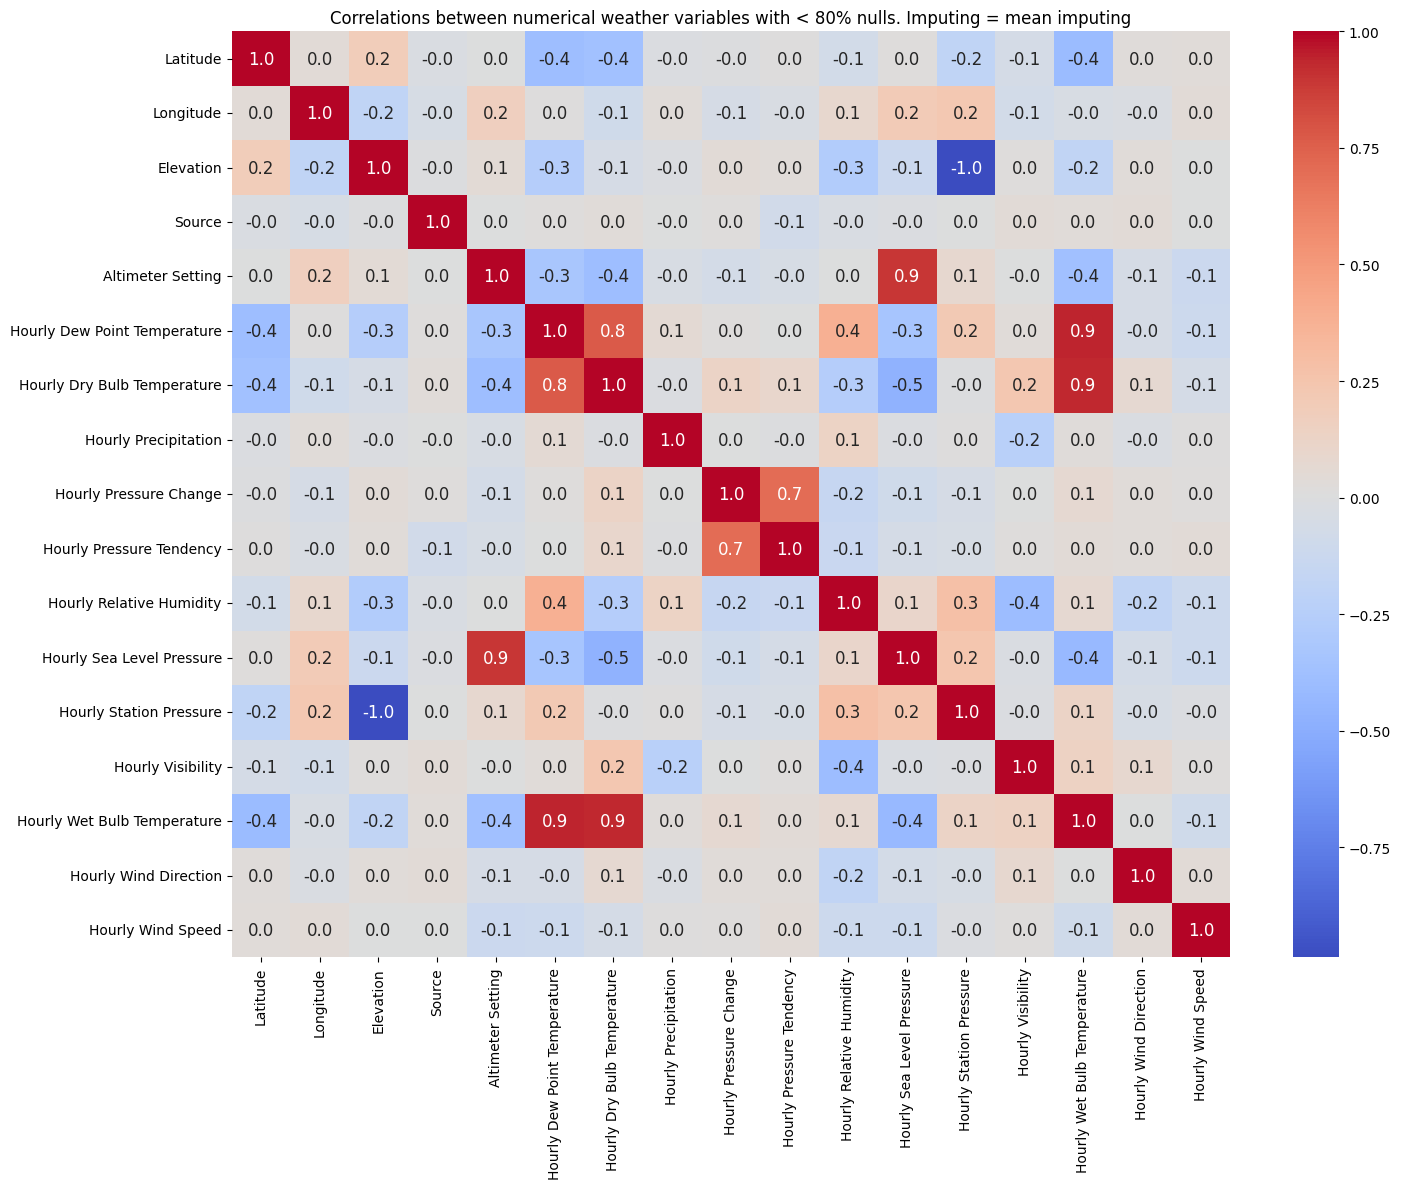

In [0]:
# Generate the heatmap
plt.figure(figsize=(15, 12))
plt.title('Correlations between numerical weather variables with < 80% nulls. Imputing = mean imputing')
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", annot_kws={"fontsize": 12}, fmt=".1f")
plt.tight_layout()
plt.savefig('weatherheatmap.png', dpi=300)
